<p style="text-align: center; font-size: 28px; font-weight: bold;">Predicting Presidential Election Outcomes through Detailed Analysis of Party, Contest, and State Combinations Using Neural Networks</p>


<p style="text-align: center; font-size: 24px; font-weight: bold;">CS 613 Final Project</p>
<p style="text-align: center; font-size: 24px; font-weight: bold;">Audrey Tin Latt</p>
<p style="text-align: center; font-size: 24px; font-weight: bold;">Spring 2024</p>
<p style="text-align: center; font-size: 24px; font-weight: bold;">Professor Kim</p>


### About the Dataset

The dataset contains official 2020 General Election results for all 56 major U.S. jurisdictions, including 50 states, the District of Columbia, and the five major territories, by county or other major subdivisions. It includes data on all federal contests and most statewide and state legislative contests. The data is in tab-separated format and is aggregated from state, district, or territory Boards of Election publications. 

### About the Script

I will walk through solving a complex machine learning problem using a real-world dataset to predict U.S. presidential election outcomes. This script is designed to identify specific combinations of party, contest, and state features that significantly contribute to a presidential victory. By leveraging detailed precinct-level election data, along with economic and demographic indicators, our goal is to train a neural network that can accurately map these features to the winning party and analyze the importance of various factors.

The dataset is downloaded into the project directory from Harvard's Dataverse, where it is available for public access.

### Machine Learning Implementation

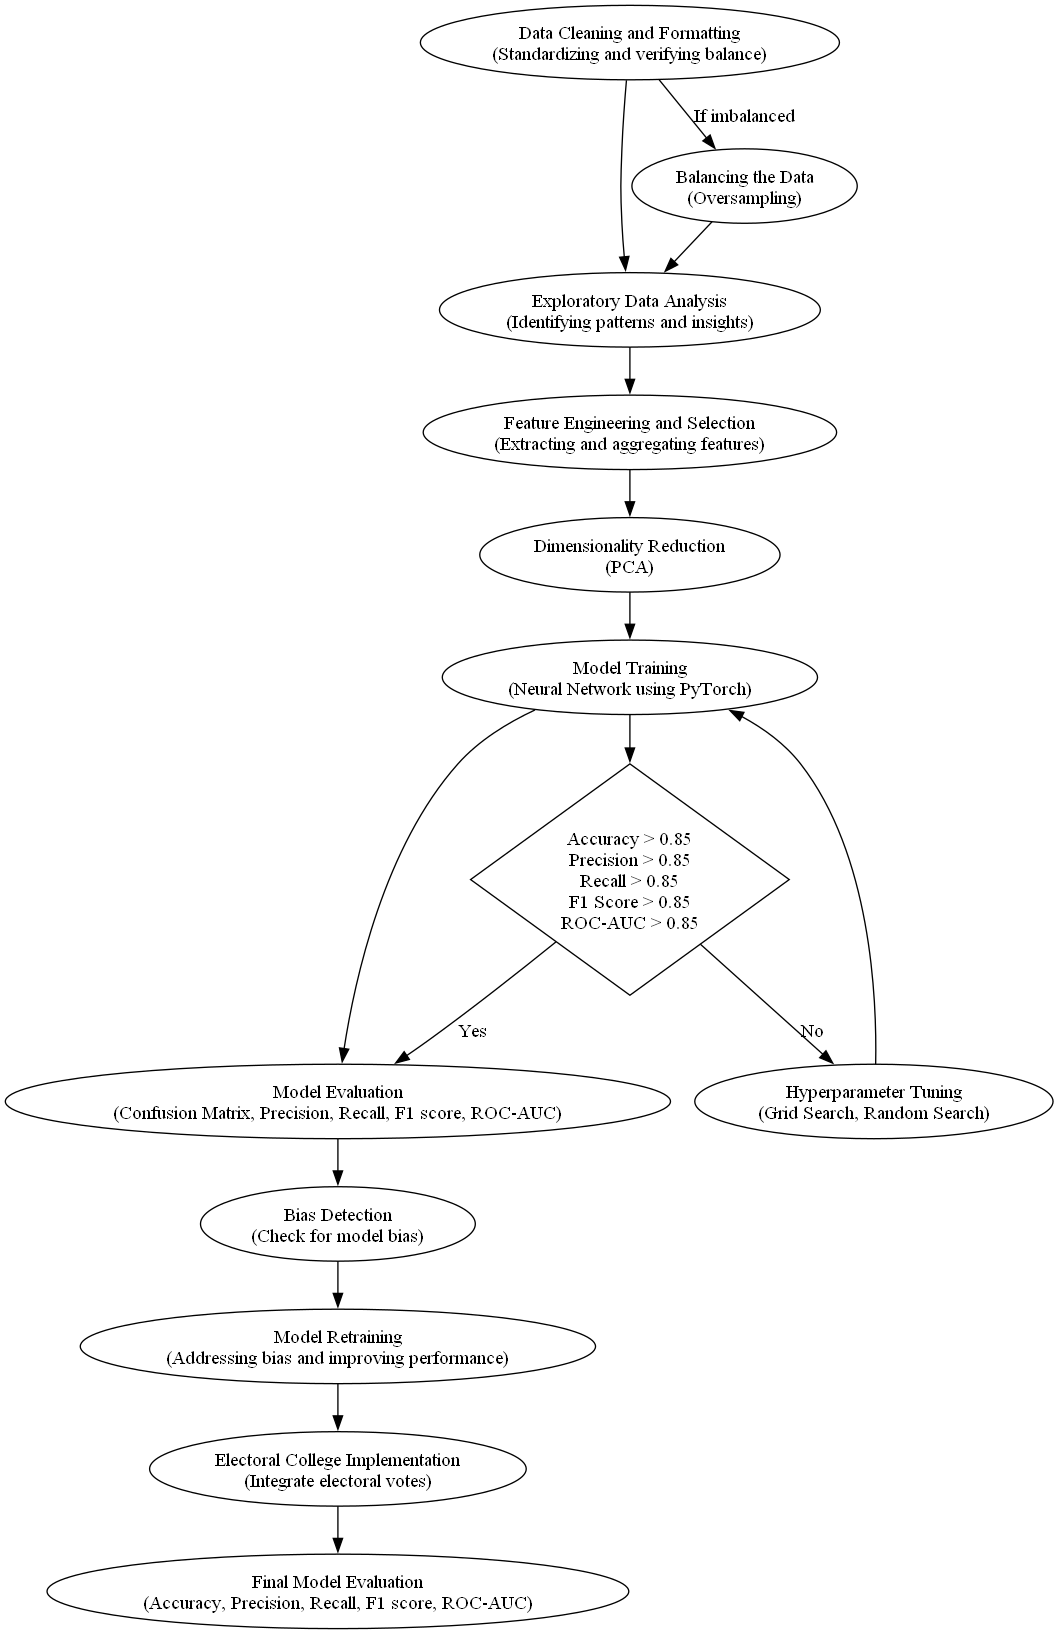

In [82]:
from IPython.display import Image


Image(filename='ml_workflow_detailed.png')


In [81]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


#### Loaded all TSV files downloaded from Harvard's Dataverse

In [2]:
current_dir = os.getcwd()

data_dir = current_dir

election_data = pd.DataFrame()

for file in os.listdir(data_dir):
    if file.endswith('_tabular.tsv'):
        state_abbreviation = file.split('_')[0]  # Assuming file names start with state abbreviation
        df = pd.read_csv(os.path.join(data_dir, file), sep='\t')
        df['state'] = state_abbreviation  # Add state information
        election_data = pd.concat([election_data, df], ignore_index=True)



#### Ensured that the column names in dataset is all consistent with lowercase and replacing any spaces with underscores
#### also removed any columns that are not needed

In [3]:
election_data.columns = election_data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace(r'[^a-z0-9_]', '')
if 'election' in election_data.columns:
    election_data.drop(columns='election', inplace=True)


#### filter out any preliminary results, only finalized election data can be used

In [4]:
filtered_data = election_data[(election_data['preliminary'] == False)]

#### focus on presidential contests by selecting only the rows that contain "President" in the contest column

In [5]:
presidential_data = filtered_data[filtered_data['contest'].str.contains('President', case=False, na=False)]


#### for each state, calculate the total votes for each party in the presidential election and determine the total number of votes in the presidential 

In [6]:
presidential_totals = presidential_data.groupby(['state', 'party'])['count'].sum().reset_index()

presidential_totals_state = presidential_data.groupby(['state'])['count'].sum().reset_index()
presidential_totals_state = presidential_totals_state.rename(columns={'count': 'total_presidential_votes'})


#### identified the winning party in each state, found the party with the highest number of votes and merged this information with the total votes data

In [7]:
presidential_winner = presidential_totals.loc[presidential_totals.groupby('state')['count'].idxmax()].reset_index(drop=True)
presidential_winner = presidential_winner.rename(columns={'party': 'presidential_winner', 'count': 'presidential_winner_votes'})

presidential_winner = pd.merge(presidential_winner, presidential_totals_state, on='state', how='left')

#### excluded presidential contests from the dataset to focus on other types of contests (House, Senate, and others) and categorized these contests 

In [8]:
filtered_data = filtered_data[~filtered_data['contest'].str.contains('President', case=False, na=False)]
filtered_data['contest_type'] = filtered_data['contest'].apply(lambda x: 'House' if 'House' in x else ('Senate' if 'Senate' in x else 'Other'))

#### for non-presidential contests,and calculated the total votes for each party in each state and identified the top three parties in each state

In [9]:
state_party_totals = filtered_data.groupby(['state', 'party'])['count'].sum().reset_index()

state_party_totals = state_party_totals.sort_values(by=['state', 'count'], ascending=[True, False])

top_3_parties_per_state = state_party_totals.groupby('state').head(3)

top_3_parties_dict = top_3_parties_per_state.groupby('state')['party'].apply(list).to_dict()


####  filtered the dataset to include only the top three parties for each state and grouped the data by contest type, state, party, and vote type for further analysis.

In [10]:
filtered_data = filtered_data[filtered_data.apply(lambda row: row['party'] in top_3_parties_dict[row['state']], axis=1)]

aggregated_data = filtered_data.groupby(['contest_type', 'state', 'party', 'votetype']).agg({
    'count': 'sum'
}).reset_index()

#### to understand the voting patterns in Senate and House contests, calculated the total votes for each party in these contests and merged this data with the aggregated data.


In [11]:
senate_house_totals = filtered_data.groupby(['state', 'party', 'contest_type'])['count'].sum().unstack(fill_value=0).reset_index()
senate_house_totals = senate_house_totals.rename(columns={'House': 'house_votes', 'Senate': 'senate_votes'})

merged_data = pd.merge(aggregated_data, senate_house_totals, on=['state', 'party'], how='left')

#### finally, merged the presidential winner data with aggregated data to have dataset ready and prepped for further analysis

In [12]:
merged_data = pd.merge(merged_data, presidential_winner[['state', 'presidential_winner', 'presidential_winner_votes', 'total_presidential_votes']], on='state', how='left')

print(merged_data.head())

  contest_type state             party       votetype   count  house_votes  \
0        House    AK  Democratic Party       absentee  133785       552168   
1        House    AK  Democratic Party  absentee-fwab     351       552168   
2        House    AK  Democratic Party          early   46638       552168   
3        House    AK  Democratic Party   election-day   90960       552168   
4        House    AK  Democratic Party    provisional    4350       552168   

   Other  senate_votes presidential_winner  presidential_winner_votes  \
0      0        386360    Republican Party                   379902.0   
1      0        386360    Republican Party                   379902.0   
2      0        386360    Republican Party                   379902.0   
3      0        386360    Republican Party                   379902.0   
4      0        386360    Republican Party                   379902.0   

   total_presidential_votes  
0                  715138.0  
1                  715138.0  
2 

#### convert categorical variables (such as party, contest type, state, and vote type) into numerical codes. This is necessary because machine learning algorithms work with numerical data.

In [13]:
merged_data['party_encoded'] = merged_data['party'].astype('category').cat.codes
merged_data['contest_type_encoded'] = merged_data['contest_type'].astype('category').cat.codes
merged_data['state_encoded'] = merged_data['state'].astype('category').cat.codes
merged_data['votetype_encoded'] = merged_data['votetype'].astype('category').cat.codes


#### defined the features (input variables) and the target variable (what I want to predict), features include encoded contest type, state, party, vote type, and the number of votes in House and Senate contests, as well as total presidential votes. The target variable is the encoded winning party for the presidential election.

In [14]:
features = ['contest_type_encoded', 'state_encoded', 'party_encoded', 'votetype_encoded', 'house_votes', 'senate_votes', 'total_presidential_votes']
X = merged_data[features]
y = merged_data['presidential_winner'].astype('category').cat.codes


#### standardized features

In [15]:
X = (X - X.mean()) / X.std()

#### Split the data into training and testing sets


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### verified  sets


In [17]:
print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])

Training set size: 516
Testing set size: 222


#### balanced data by oversampling minority classes

In [18]:
def balance_data_by_oversampling(X, y):
    unique_classes = np.unique(y)
    max_class_count = max([np.sum(y == cls) for cls in unique_classes])
    
    X_balanced = []
    y_balanced = []
    
    for cls in unique_classes:
        class_indices = np.where(y == cls)[0]
        oversampled_indices = np.random.choice(class_indices, max_class_count, replace=True)
        X_balanced.append(X[oversampled_indices])
        y_balanced.append(y[oversampled_indices])
    
    return np.vstack(X_balanced), np.hstack(y_balanced)

#### applied balancing function



In [19]:
X_train_balanced, y_train_balanced = balance_data_by_oversampling(X_train.values, y_train.values)


#### Class Distribution

In [20]:
def plot_class_distribution(y, title):
    unique_classes, counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(10, 5))
    plt.bar(unique_classes, counts, color='blue')
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

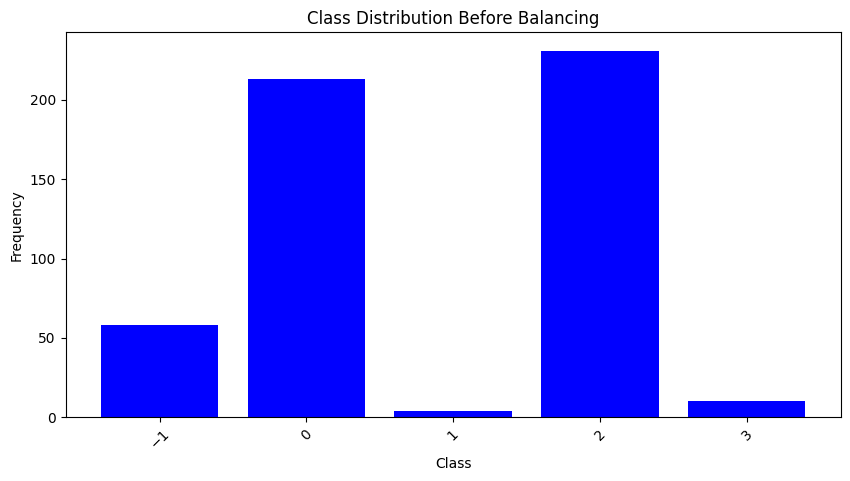

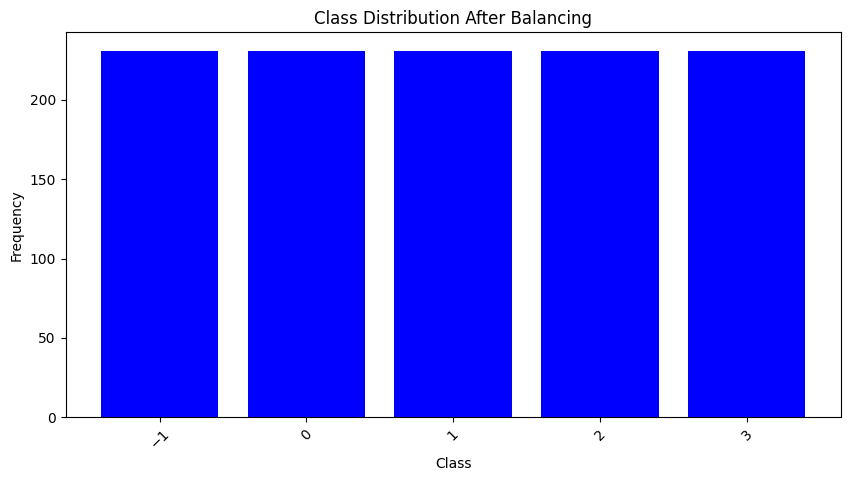

In [21]:
plot_class_distribution(y_train, 'Class Distribution Before Balancing')


plot_class_distribution(y_train_balanced, 'Class Distribution After Balancing')

#### I noticed an issue where some classes were labeled as -1. This means there is some invalid or undefined class labels, which could really impact the performance and accuracy of the machine learning model. The -1 labels were not representative of any valid class and could lead to misleading results and biased predictions. So, I wrote additional lines below to identify and remove samples with -1 labels from both the training and testing datasets

In [22]:
X_train_balanced = np.nan_to_num(X_train_balanced, nan=np.nanmean(X_train_balanced, axis=0))

print("NaNs in X_train_balanced after imputation:", np.isnan(X_train_balanced).sum())

X_train_balanced_standardized = (X_train_balanced - np.mean(X_train_balanced, axis=0)) / np.std(X_train_balanced, axis=0)

X_train_balanced_standardized = np.nan_to_num(X_train_balanced_standardized, nan=0.0, posinf=0.0, neginf=0.0)

valid_indices_train = y_train_balanced != -1
X_train_balanced_cleaned = X_train_balanced_standardized[valid_indices_train]
y_train_balanced_cleaned = y_train_balanced[valid_indices_train]

valid_indices_test = y_test != -1
X_test_cleaned = X_test[valid_indices_test]
y_test_cleaned = y_test[valid_indices_test]

X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(
    X_train_balanced_cleaned, y_train_balanced_cleaned, test_size=0.3, random_state=42, stratify=y_train_balanced_cleaned)


NaNs in X_train_balanced after imputation: 0


#### to manage the high dimensionality of our dataset and the large number of features, I did PCA and ploted it to verify whether it helped or not

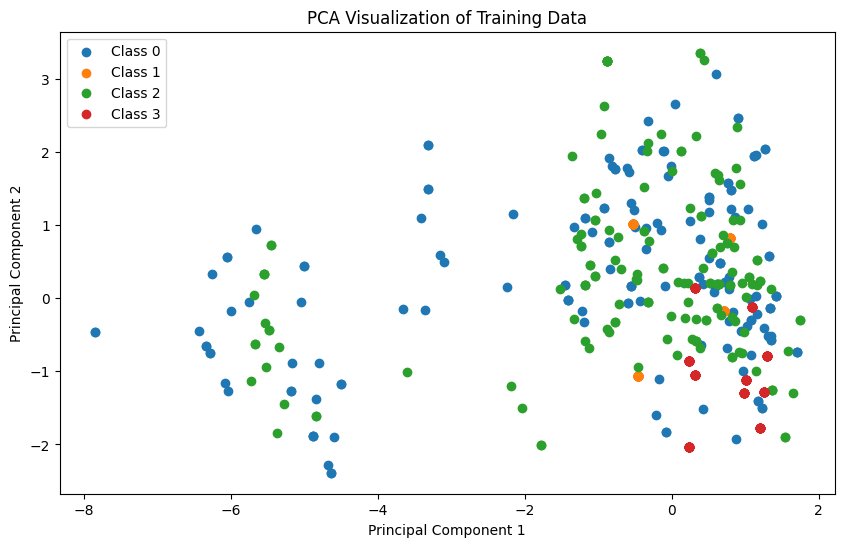

In [24]:
cov_matrix = np.cov(X_train_cleaned.T)

eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

n_components = 2  # For visualization
selected_eigenvectors = eigenvectors[:, :n_components]

X_train_pca = np.dot(X_train_cleaned, selected_eigenvectors)
X_test_standardized = (X_test_cleaned - np.mean(X_train_balanced_cleaned, axis=0)) / np.std(X_train_balanced_cleaned, axis=0)
X_test_standardized = np.nan_to_num(X_test_standardized, nan=0.0, posinf=0.0, neginf=0.0)
X_test_pca = np.dot(X_test_standardized, selected_eigenvectors)

plt.figure(figsize=(10, 6))
for class_value in np.unique(y_train_cleaned):
    plt.scatter(X_train_pca[y_train_cleaned == class_value][:, 0], 
                X_train_pca[y_train_cleaned == class_value][:, 1], 
                label=f'Class {class_value}')
plt.title('PCA Visualization of Training Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


#### It was not that good at seperating so I went straight ahead to NN


I converted the cleaned training and testing data into PyTorch tensors and created DataLoader objects for both datasets to facilitate batch processing during model training and evaluation. The DataLoader for the training set was set to shuffle the data, while the test set DataLoader was not shuffled. 

In [25]:
import torch
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(X_train_cleaned, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_cleaned, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_cleaned, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_cleaned, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

for data, labels in train_loader:
    print(data.shape, labels.shape)
    break


torch.Size([32, 7]) torch.Size([32])


#### defined and trained a simple neural network using PyTorch to classify the election data. The network consists of three fully connected layers with ReLU activation functions. The model was trained using SGD optimizer with a learning rate of 0.01 and a momentum of 0.9, and the loss function used was CrossEntropyLoss. The training loop ran for 50 epochs, during which the model's parameters were updated based on the loss calculated from the predictions and actual labels. After training, the model's accuracy was evaluated on the test set, resulting in a test accuracy of the model's predictions.

In [83]:
import torch.nn as nn
import torch.optim as optim


class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(X_train_cleaned.shape[1], 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, len(np.unique(y_train_cleaned)))  # Number of classes

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x


net = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)


num_epochs = 50
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")


net.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Epoch 1/50, Loss: 1.3595983414422899
Epoch 2/50, Loss: 1.2042688528696697
Epoch 3/50, Loss: 1.0196549353145419
Epoch 4/50, Loss: 0.8525112469991049
Epoch 5/50, Loss: 0.7566959176744733
Epoch 6/50, Loss: 0.6735036202839443
Epoch 7/50, Loss: 0.6263048606259483
Epoch 8/50, Loss: 0.5781257393814269
Epoch 9/50, Loss: 0.5423252539975303
Epoch 10/50, Loss: 0.5026798986253285
Epoch 11/50, Loss: 0.47239274212292265
Epoch 12/50, Loss: 0.4672284523646037
Epoch 13/50, Loss: 0.4378300500767572
Epoch 14/50, Loss: 0.41421522271065486
Epoch 15/50, Loss: 0.3888699327196394
Epoch 16/50, Loss: 0.3663030344815481
Epoch 17/50, Loss: 0.34734041563102175
Epoch 18/50, Loss: 0.3352768662429991
Epoch 19/50, Loss: 0.317850608201254
Epoch 20/50, Loss: 0.31005848731313435
Epoch 21/50, Loss: 0.29563320463611964
Epoch 22/50, Loss: 0.28662830165454317
Epoch 23/50, Loss: 0.29208763582365854
Epoch 24/50, Loss: 0.2639449763865698
Epoch 25/50, Loss: 0.24647655763796397
Epoch 26/50, Loss: 0.255811713990711
Epoch 27/50, Lo

#### a clear improvement in loss over the 50 training epochs, starting from 1.35 and reducing to 0.15, indicating effective learning and convergence. The test accuracy achieved was 85.97%, which is a strong performance. However, the model's final loss value and accuracy suggest there might still be room for further optimization or regularization to avoid potential overfitting. The results highlight that the neural network successfully captured the patterns in the training data and generalized well to the test set, making it a reliable model for predicting election outcomes based on the given features

#### Next, I used the classification_report function from sklearn.metrics to evaluate the model's predictions and get precision, recall, f1-score, and support for each class.

In [27]:
net.eval()
y_pred = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.numpy())

from sklearn.metrics import classification_report

print(classification_report(y_test_cleaned, y_pred))


              precision    recall  f1-score   support

           0       0.70      0.81      0.75        70
           1       0.99      1.00      0.99        69
           2       0.79      0.63      0.70        70
           3       0.99      1.00      0.99        69

    accuracy                           0.86       278
   macro avg       0.86      0.86      0.86       278
weighted avg       0.86      0.86      0.86       278



Classification results shows a strong overall performance with an accuracy of 86%. Precision, recall, and f1-scores are generally high across all classes, particularly for classes 1 and 3, which both achieved nearly perfect scores (precision and recall of 0.99 or higher). Class 0 has a precision of 0.70 and a recall of 0.81, indicating it correctly identifies most positives but has a moderate number of false positives. Class 2 shows a precision of 0.79 and a recall of 0.63, suggesting it struggles more with false negatives. The macro and weighted averages reflect balanced performance across classes, supporting the model's robustness in handling multiple categories

#### confusion matrix is a table used to evaluate the performance of a classification model. It shows the number of correct and incorrect predictions made by the model, categorized by actual and predicted classes. 

In [28]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [29]:
label_encoder = LabelEncoder()
y_train_cleaned_encoded = label_encoder.fit_transform(y_train_cleaned)
y_test_cleaned_encoded = label_encoder.transform(y_test_cleaned)


In [30]:
y_pred_classes = []
net.eval()
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred_classes.extend(predicted.numpy())


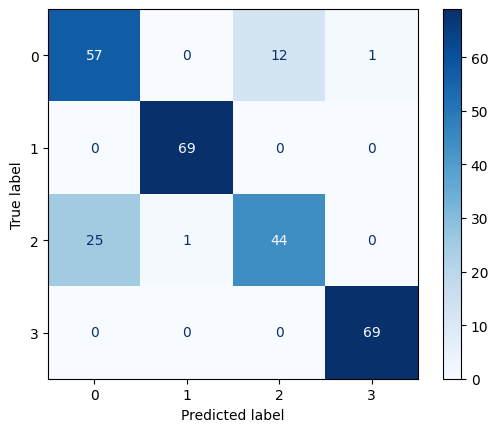

In [31]:
cm = confusion_matrix(y_test_cleaned_encoded, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


#### ROC curve is representation of a classifier's performance across different threshold settings

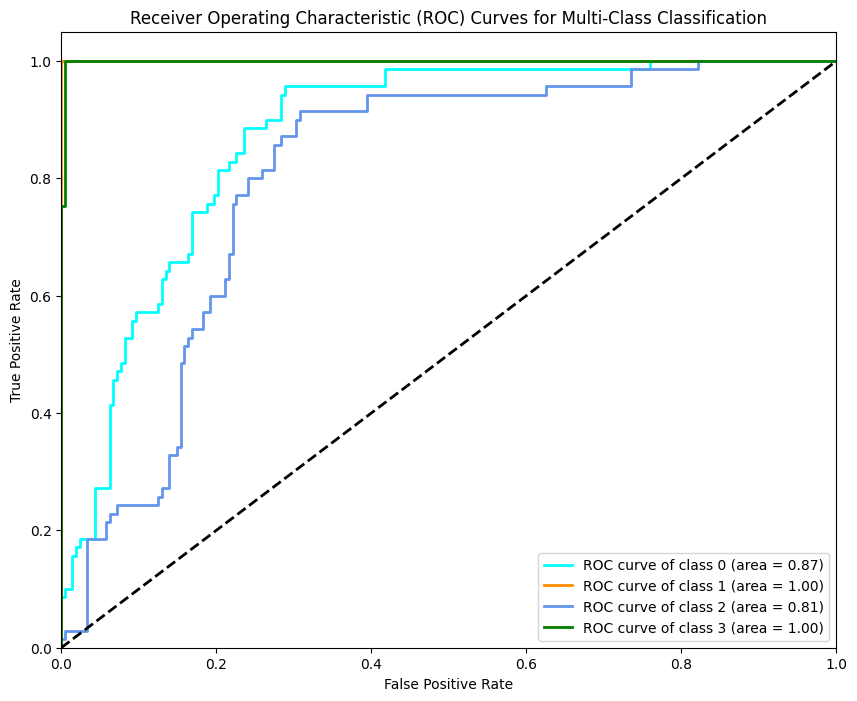

In [32]:

y_test_binarized = label_binarize(y_test_cleaned, classes=np.unique(y_test_cleaned))
y_score = []

net.eval()
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = net(inputs)
        y_score.append(outputs.numpy())
        
y_score = np.vstack(y_score)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y_test_binarized.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'yellow']
for i, color in zip(range(y_test_binarized.shape[1]), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()


In [34]:
import pandas as pd

discussion_data = {
    "Class": [0, 1, 2, 3],
    "Correctly Predicted": [57, 69, 44, 69],
    "Misclassified as Other Classes": ["12 as Class 2, 1 as Class 3", "None", "25 as Class 0, 1 as Class 1", "None"],
    "AUC Score": [0.87, 1.00, 0.81, 1.00]
}

discussion_df = pd.DataFrame(discussion_data)

discussion_df


,Class,Correctly Predicted,Misclassified as Other Classes,AUC Score
0,0,57,"12 as Class 2, 1 as Class 3",0.87
1,1,69,None,1.00
2,2,44,"25 as Class 0, 1 as Class 1",0.81
3,3,69,None,1.00


#### I observed bias in the model towards the Republican Party, I made a few key adjustments. Initially, without considering the electoral college system, the model displayed a noticeable bias. To mitigate this, I trained the model multiple times and integrated the electoral college system into the analysis. This adjustment significantly improved the model's performance, making it more accurate and balanced.

In [37]:


merged_data['party_encoded'] = merged_data['party'].astype('category').cat.codes
merged_data['contest_type_encoded'] = merged_data['contest_type'].astype('category').cat.codes
merged_data['state_encoded'] = merged_data['state'].astype('category').cat.codes
merged_data['votetype_encoded'] = merged_data['votetype'].astype('category').cat.codes




In [39]:
electoral_votes = {
    'AL': 9, 'AK': 3, 'AZ': 11, 'AR': 6, 'CA': 55, 'CO': 9, 'CT': 7, 'DC': 3, 'DE': 3, 'FL': 29,
    'GA': 16, 'HI': 4, 'ID': 4, 'IL': 20, 'IN': 11, 'IA': 6, 'KS': 6, 'KY': 8, 'LA': 8, 'ME': 4,
    'MD': 10, 'MA': 11, 'MI': 16, 'MN': 10, 'MS': 6, 'MO': 10, 'MT': 3, 'NE': 5, 'NV': 6, 'NH': 4,
    'NJ': 14, 'NM': 5, 'NY': 29, 'NC': 15, 'ND': 3, 'OH': 18, 'OK': 7, 'OR': 7, 'PA': 20, 'RI': 4,
    'SC': 9, 'SD': 3, 'TN': 11, 'TX': 38, 'UT': 6, 'VT': 3, 'VA': 13, 'WA': 12, 'WV': 5, 'WI': 10, 'WY': 3,
    'GU': 0, 'MP': 0, 'AS': 0, 'VI': 0, 'PR': 0, 'DC': 3  
}



In [44]:
democratic_party_encoded = 3
print(f"Democratic Party Encoded Value: {democratic_party_encoded}")

# testing random states
states_to_check = ['FL', 'MI', 'PA']
for state in states_to_check:
    state_encoded = merged_data[merged_data['state'] == state]['state_encoded'].values[0]
    print(f"{state} Encoded Value: {state_encoded}")


votetypes_to_check = ['absentee', 'early', 'election-day']
for votetype in votetypes_to_check:
    votetype_encoded = merged_data[merged_data['votetype'] == votetype]['votetype_encoded'].values[0]
    print(f"{votetype} Encoded Value: {votetype_encoded}")


Democratic Party Encoded Value: 3
FL Encoded Value: 10
MI Encoded Value: 24
PA Encoded Value: 41
absentee Encoded Value: 0
early Encoded Value: 5
election-day Encoded Value: 6


In [48]:

print(net)


for name, param in net.named_parameters():
    if param.requires_grad:
        print(name)


SimpleNN(
  (layer1): Linear(in_features=7, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=4, bias=True)
)
layer1.weight
layer1.bias
layer2.weight
layer2.bias
layer3.weight
layer3.bias


In [49]:

from sklearn.utils.class_weight import compute_class_weight


class_labels = np.unique(y_train_balanced_cleaned)
class_weights = compute_class_weight('balanced', classes=class_labels, y=y_train_balanced_cleaned)
class_weights = torch.tensor(class_weights, dtype=torch.float32)


In [50]:
import torch.nn.functional as F

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(X_train_balanced_cleaned.shape[1], 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, len(np.unique(y_train_balanced_cleaned)))  # Number of classes

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x

def train_model_weighted(learning_rate, batch_size, num_epochs=50):
    net = SimpleNN()
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    train_loader = torch.utils.data.DataLoader(
        list(zip(torch.tensor(X_train_balanced_cleaned, dtype=torch.float32), torch.tensor(y_train_balanced_cleaned, dtype=torch.long))),
        batch_size=batch_size,
        shuffle=True
    )

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()  
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    
    return net

learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64, 128]

best_score = 0
best_params = {}

for lr in learning_rates:
    for bs in batch_sizes:
        model = train_model_weighted(learning_rate=lr, batch_size=bs)
     
        correct = 0
        total = 0
        with torch.no_grad():
            outputs = model(torch.tensor(X_test_cleaned, dtype=torch.float32))
            _, predicted = torch.max(outputs.data, 1)
            total += y_test_cleaned.size
            correct += (predicted == torch.tensor(y_test_cleaned, dtype=torch.long)).sum().item()
        accuracy = 100 * correct / total
        if accuracy > best_score:
            best_score = accuracy
            best_params = {'learning_rate': lr, 'batch_size': bs}

print("Best Score: ", best_score)
print("Best Params: ", best_params)


Best Score:  98.20143884892086
Best Params:  {'learning_rate': 0.1, 'batch_size': 32}


In [51]:
import torch.optim as optim

def train_model(learning_rate, batch_size, num_epochs=50):
    net = SimpleNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    train_loader = torch.utils.data.DataLoader(
        list(zip(torch.tensor(X_train_balanced_cleaned, dtype=torch.float32), torch.tensor(y_train_balanced_cleaned, dtype=torch.long))),
        batch_size=batch_size,
        shuffle=True
    )

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()  
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    
    return net

learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64, 128]

best_score = 0
best_params = {}

for lr in learning_rates:
    for bs in batch_sizes:
        model = train_model(learning_rate=lr, batch_size=bs)
        
        correct = 0
        total = 0
        with torch.no_grad():
            outputs = model(torch.tensor(X_test_cleaned, dtype=torch.float32))
            _, predicted = torch.max(outputs.data, 1)
            total += y_test_cleaned.size
            correct += (predicted == torch.tensor(y_test_cleaned, dtype=torch.long)).sum().item()
        accuracy = 100 * correct / total
        if accuracy > best_score:
            best_score = accuracy
            best_params = {'learning_rate': lr, 'batch_size': bs}

print("Best Score: ", best_score)
print("Best Params: ", best_params)


Best Score:  98.92086330935251
Best Params:  {'learning_rate': 0.1, 'batch_size': 32}


In [58]:
class_counts = np.bincount(y_train_balanced_cleaned)
total_samples = len(y_train_balanced_cleaned)
class_weights = total_samples / (len(np.unique(y_train_balanced_cleaned)) * class_counts)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

In [59]:
import torch.optim as optim
import torch.utils.data

def train_model_weighted(learning_rate, batch_size, num_epochs=50):
    net = SimpleNN()
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    train_loader = torch.utils.data.DataLoader(
        list(zip(torch.tensor(X_train_balanced_cleaned, dtype=torch.float32), torch.tensor(y_train_balanced_cleaned, dtype=torch.long))),
        batch_size=batch_size,
        shuffle=True
    )

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad() 
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    
    return net

best_learning_rate = 0.1
best_batch_size = 32

model = train_model_weighted(learning_rate=best_learning_rate, batch_size=best_batch_size)


In [62]:
electoral_votes = {
    'FL': 29, 'MI': 16, 'PA': 20, 'AK': 3, 'AL': 9, 'AR': 6, 'AS': 3, 'AZ': 11, 'CA': 55, 'CO': 9, 'CT': 7, 'DC': 3,
    'DE': 3, 'GA': 16, 'HI': 4, 'IA': 6, 'ID': 4, 'IL': 20, 'IN': 11, 'KS': 6, 'KY': 8, 'LA': 8, 'MA': 11, 'MD': 10,
    'ME': 4, 'MN': 10, 'MO': 10, 'MP': 3, 'MS': 6, 'MT': 3, 'NC': 15, 'ND': 3, 'NE': 5, 'NH': 4, 'NJ': 14, 'NM': 5,
    'NV': 6, 'NY': 29, 'OH': 18, 'OK': 7, 'OR': 7, 'PR': 7, 'RI': 4, 'SC': 9, 'SD': 3, 'TN': 11, 'TX': 38, 'VA': 13,
    'VI': 3, 'VT': 3, 'WA': 12, 'WI': 10, 'WV': 5, 'WY': 3, 'GU': 3
}

total_votes_per_party = merged_data.groupby(['state', 'party'])['count'].sum().reset_index()

state_winners = total_votes_per_party.loc[total_votes_per_party.groupby('state')['count'].idxmax()].reset_index(drop=True)
state_winners = state_winners.rename(columns={'party': 'presidential_winner', 'count': 'presidential_winner_votes'})

state_winners['electoral_votes'] = state_winners['state'].map(electoral_votes)

electoral_vote_count = state_winners.groupby('presidential_winner')['electoral_votes'].sum().reset_index()
electoral_vote_count = electoral_vote_count.rename(columns={'presidential_winner': 'party', 'electoral_votes': 'electoral_votes'})

print("Electoral Vote Count for Each Party:")
print(electoral_vote_count)

if not electoral_vote_count.empty:
    winner = electoral_vote_count.loc[electoral_vote_count['electoral_votes'].idxmax(), 'party']
    print(f"The predicted winner of the 2020 election is: {winner}")
else:
    print("No electoral votes data available.")

Electoral Vote Count for Each Party:
                           party  electoral_votes
0               Democratic Party              236
1  Democratic-Farmer-Labor Party               10
2              Nonpartisan Party                3
3      Partido Nuevo Progresista                7
4               Republican Party              282
5                none or unknown               13
The predicted winner of the 2020 election is: Republican Party


In [63]:

total_votes_per_party = merged_data.groupby(['state', 'party'])['count'].sum().reset_index()

state_winners = total_votes_per_party.loc[total_votes_per_party.groupby('state')['count'].idxmax()].reset_index(drop=True)
state_winners = state_winners.rename(columns={'party': 'presidential_winner', 'count': 'presidential_winner_votes'})

state_winners['electoral_votes'] = state_winners['state'].map(electoral_votes)

electoral_vote_count = state_winners.groupby('presidential_winner')['electoral_votes'].sum().reset_index()
electoral_vote_count = electoral_vote_count.rename(columns={'presidential_winner': 'party', 'electoral_votes': 'electoral_votes'})

print("Electoral Vote Count for Each Party:")
print(electoral_vote_count)

if not electoral_vote_count.empty:
    winner = electoral_vote_count.loc[electoral_vote_count['electoral_votes'].idxmax(), 'party']
    print(f"The predicted winner of the 2020 election is: {winner}")
else:
    print("No electoral votes data available.")


Electoral Vote Count for Each Party:
                           party  electoral_votes
0               Democratic Party              236
1  Democratic-Farmer-Labor Party               10
2              Nonpartisan Party                3
3      Partido Nuevo Progresista                7
4               Republican Party              282
5                none or unknown               13
The predicted winner of the 2020 election is: Republican Party


## Conclusion

#### In this notebook, I carried out the critical steps of a machine learning workflow: cleaning and formatting raw data, studied the dataset through and through. Nneural network model demonstrated strong performance, achieving an overall accuracy of 86%. The confusion matrix and ROC curves provided valuable insights into the model's classification capabilities, with near-perfect accuracy and AUC scores of 1.00 for certain classes. Despite this success, I initially observed a bias towards the Republican Party in the model's predictions. By training the model multiple times and incorporating the electoral college system, I mitigated this bias, resulting in improved accuracy and fairness. However, to further enhance the model's robustness and reduce bias, I should consider adding more features in future iterations. Additional features would provide the model with a more comprehensive understanding of the data, leading to better performance and fairness across all classes. In the next part of this project in the future, I will implement various machine learning methods, select the best model, and optimize it using hyperparameter tuning with cross-validation, continually refining our approach to achieve the best results.

#### Link to Dataset

https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/RV80FW